## Binary Classification - Titanic: Machine Learning from Disaster

https://www.kaggle.com/c/titanic

- 유명한 자료인 타이타닉 데이터 셋으로 생존과 사망에 대한 분류 문제를 풀어보도록 하겠습니다.

![대체 텍스트](https://github.com/Chan-Sicpama/gcs/blob/main/figures2/binary.png?raw=1)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt 

random.seed(1215)
torch.manual_seed(1215)

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load Data

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('{name} Uploaded.'.format(name=fn))

Saving test.csv to test.csv
Saving train.csv to train.csv
test.csv Uploaded.
train.csv Uploaded.


In [4]:
import pandas as pd

train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [5]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


# Preprocessing
- Pclass, Sex, Age, SibSp, Parch, Fare 총 6개의 feature를 사용하겠습니다.
- 별도의 feature engineering은 하지 않겠습니다.
- kaggle data이기 때문에 test_data의 "Survived" 열은 없습니다.
- 우리가 예측한 결과를 csv 파일로 제출하는 형태입니다.

### categorical variable 처리

In [7]:
train_data["Sex"].head(10)

0      male
1    female
2    female
3    female
4      male
5      male
6      male
7      male
8    female
9    female
Name: Sex, dtype: object

In [8]:
train_data["Sex"] = train_data["Sex"].map({"male": 1, "female": 0})
test_data["Sex"] = test_data["Sex"].map({"male": 1, "female": 0})

In [9]:
train_data["Sex"].head(10)

0    1
1    0
2    0
3    0
4    1
5    1
6    1
7    1
8    0
9    0
Name: Sex, dtype: int64

### 데이터셋 구성

In [10]:
data_X = train_data[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
data_y = train_data["Survived"]

In [11]:
len(data_X)

891

In [12]:
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.3)

In [13]:
len(train_X), len(data_X)*.7

(623, 623.6999999999999)

In [14]:
len(test_X), len(data_X)*.3

(268, 267.3)

### null 값 확인 (결측값)

In [15]:
print('Number of null in train_X:', train_X.isnull().sum())
print("\n",'Number of null in test_X:', test_X.isnull().sum())
print("\n",'Number of nullin train y:', train_y.isnull().sum())
print("\n",'Number of nullin train y:', test_y.isnull().sum())

print("\n",np.mean(train_X["Age"]))

Number of null in train_X: Pclass      0
Sex         0
Age       131
SibSp       0
Parch       0
Fare        0
dtype: int64

 Number of null in test_X: Pclass     0
Sex        0
Age       46
SibSp      0
Parch      0
Fare       0
dtype: int64

 Number of nullin train y: 0

 Number of nullin train y: 0

 29.600609756097562


- 간단하게 age와 fare의 na 값은 평균으로 대체

In [16]:
pd.options.mode.chained_assignment = None

train_X.loc[:,"Age"] = train_X.loc[:,"Age"].replace(np.nan,30)
test_X.loc[:,"Age"] = test_X.loc[:,"Age"].replace(np.nan,30)

In [17]:
print('Number of null:', train_X.isnull().sum())
print("\n",'Number of null:', test_X.isnull().sum())

Number of null: Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

 Number of null: Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


In [18]:
train_y.head()

768    0
39     1
747    1
197    0
628    0
Name: Survived, dtype: int64

In [19]:
len(train_X), len(test_X), len(train_y), len(test_y)

(623, 268, 623, 268)

# Train model (PyTorch)
1. dataset, dataloader 정의
2. 모델 정의
3. 모델 학습 
4. 모델 평가

- train, test dataset을 출력할 수 있는 class를 만듭니다.

In [20]:
class simple_dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data # float
        self.y_data = y_data # 0,1 int => long으로 많이 쓴다
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [21]:
type(test_X)

pandas.core.frame.DataFrame

In [22]:
# 정규화합니다
scaler = StandardScaler()
train_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(train_X.to_numpy())), torch.LongTensor(train_y.to_numpy()))
test_data = simple_dataset(torch.FloatTensor(scaler.fit_transform(test_X.to_numpy())), torch.LongTensor(test_y.to_numpy()))

In [23]:
len(train_data), len(test_data)

(623, 268)

In [24]:
train_data.__getitem__(0)

(tensor([ 0.8457,  0.7493,  0.0253,  0.4552, -0.4722, -0.1672]), tensor(0))

In [25]:
train_data[0]

(tensor([ 0.8457,  0.7493,  0.0253,  0.4552, -0.4722, -0.1672]), tensor(0))

## Modeling

In [29]:
class Binary_Classification(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(Binary_Classification, self).__init__()
        
        self.Layer_1 = nn.Linear(num_features, 30) # (mini batch에 들어있는 item 개수, 6(num_features) ) ->(mini batch에 들어있는 item 개수 , 30 )
        self.Layer_2 = nn.Linear(30,20) 
        self.Layer_3 = nn.Linear(20,10)
        self.Layer_out = nn.Linear(10, num_classes)
        ################################################
        #  TODO    Layer 만들기                        #
        ################################################
        
        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        x = self.Layer_1(inputs)
        x = self.relu(x)
        x = self.Layer_2(x)
        x = self.relu(x)
        x = self.Layer_3(x)
        x = self.relu(x)
        ################################################
        #  TODO       feature를 layer를 통과시키기     #
        ################################################

        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################
        
        x = self.Layer_out(x)

        return x

## Training

In [36]:
EPOCHS = 3000
BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

model = Binary_Classification(num_features=6, num_classes=2)

criterion = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/nn.html
optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate 0.01~ 0.0001 가장 많이 쓰인다. 

### 데이터 사이즈 확인 

In [37]:
for epoch in range(EPOCHS):
    for X_batch, y_batch in train_loader:
        print(X_batch.size(), y_batch.size())
        break
    break

torch.Size([128, 6]) torch.Size([128])


In [38]:
loss_list = []
acc_list = []
for epoch in range(EPOCHS):
    for i, (X_batch, y_batch) in enumerate(train_loader):
        
        #Forward 
        y_output = model(X_batch)
        loss = criterion(y_output, y_batch) #CELoss: The input is expected to contain raw, unnormalized scores for each class.
        
        #Backward
        optimizer.zero_grad()
        loss.backward() # gradient 연산, 값들은 model.parameters()에 있다. 
        optimizer.step() # descent 연산
        
        #misc (acc 계산, etc) 
        y_pred = torch.max(y_output, 1)[1]
        acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu())
        loss_list.append(loss.item())
        acc_list.append(acc)

    if (epoch+1) % 30 == 0:
        print('Epoch [{}/{}] Step [{}/{}] Loss: [{:.4f}] Train ACC [{:.2f}%]'.format(epoch+1, EPOCHS, \
                                                                                   i+1, len(train_loader), loss.item(), acc*100))

Epoch [30/3000] Step [5/5] Loss: [0.4294] Train ACC [84.68%]
Epoch [60/3000] Step [5/5] Loss: [0.4150] Train ACC [84.68%]
Epoch [90/3000] Step [5/5] Loss: [0.3012] Train ACC [90.09%]
Epoch [120/3000] Step [5/5] Loss: [0.4410] Train ACC [80.18%]
Epoch [150/3000] Step [5/5] Loss: [0.3654] Train ACC [85.59%]
Epoch [180/3000] Step [5/5] Loss: [0.3321] Train ACC [86.49%]
Epoch [210/3000] Step [5/5] Loss: [0.3093] Train ACC [86.49%]
Epoch [240/3000] Step [5/5] Loss: [0.3355] Train ACC [85.59%]
Epoch [270/3000] Step [5/5] Loss: [0.2580] Train ACC [91.89%]
Epoch [300/3000] Step [5/5] Loss: [0.2946] Train ACC [90.09%]
Epoch [330/3000] Step [5/5] Loss: [0.2110] Train ACC [92.79%]
Epoch [360/3000] Step [5/5] Loss: [0.3181] Train ACC [85.59%]
Epoch [390/3000] Step [5/5] Loss: [0.3205] Train ACC [88.29%]
Epoch [420/3000] Step [5/5] Loss: [0.4012] Train ACC [81.98%]
Epoch [450/3000] Step [5/5] Loss: [0.3542] Train ACC [83.78%]
Epoch [480/3000] Step [5/5] Loss: [0.2936] Train ACC [86.49%]
Epoch [510/

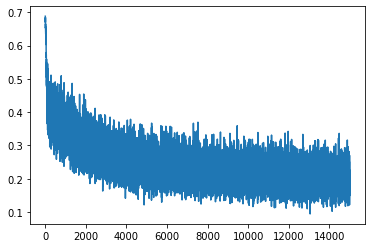

In [39]:
plt.plot(loss_list)

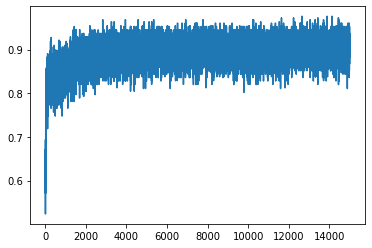

In [40]:
plt.plot(acc_list)

## Test

In [41]:
test_y_pred = []
test_acc_list = []
with torch.no_grad():

    for X_batch, y_batch in test_loader:    
        #Forward
        y_output = model(X_batch)
        
        #misc (acc 계산, etc) 
        y_pred = torch.max(y_output, 1)[1]
        test_y_pred.append(y_pred) ##
        
        acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu())
        test_acc_list.append(acc)
    test_acc = np.mean(test_acc_list)
print('Test ACC: [{:.2f}%]'.format(test_acc*100))

Test ACC: [79.10%]


In [42]:
len(test_y_pred), test_y_pred[:10]

(268,
 [tensor([1]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([1]),
  tensor([1])])

# *Alternative code*

In [ ]:
class Binary_Classification_layer(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(Binary_Classification_layer, self).__init__()
        
        self.Layer_1 = nn.Linear(num_feature, num_classes)
                     
        
        ################################################
        #       TODO                                   #
        ################################################

        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################


    def forward(self, inputs):
        
        x = self.Layer_1(inputs)      
        
        ################################################
        #       TODO                                   #
        ################################################    
        
        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################


        return x

# *Assignment*

- 본인만의 모델을 만들어 Test ACC 79%를 달성해보세요!

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 200

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

model = Binary_Classification_layer(num_features=6, num_classes=2)

criterion = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/nn.html
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
train_loss_list = []
train_acc_list = []

test_acc_list = []
model.cuda()
for epoch in range(EPOCHS):
    # train
    model.train() # 학습을 할 때 , test는 model.eval()
    for x,y in train_loader:
        ################################################
        #       TODO                                   #
        ################################################ 
        X_batch = x.cuda()
        y_batch = y.cuda()
        
        #Forward 
        y_output = model(X_batch) # gpu 
        loss = criterion(y_output, y_batch)  #CELoss: The input is expected to contain raw, unnormalized scores for each class.
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.zero_grad()
        
        #misc (acc 계산, etc) 
        y_pred = torch.max(y_output, 1)[1]
        train_acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu())
        train_loss_list.append(loss.item())
        train_acc_list.append(train_acc)

        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################

    
        
    # test
    with torch.no_grad():
      model.eval()
      for x,y in test_loader:
        X_batch = x.cuda()
        y_batch = y.cuda()
        y_output = model(X_batch)
        ################################################
        #       TODO                                   #
        ################################################ 
        #Forward

        
        #misc (acc 계산, etc) 
        y_pred = torch.max(y_output, 1)[1]
        test_acc = accuracy_score(y_pred.data.cpu(), y_batch.data.cpu())
        test_acc_list.append(test_acc)

        ################################################
        #  가능한 답은 하나가 아니므로 성능이 더 좋을  #
        #  법할 모델을 다양하게 시도해보시길 바랍니다  #
        ################################################

    
    if (epoch+1) % 30 == 0:
        print('Epoch [{}/{}] Step [{}/{}] Loss: [{:.4f}] Train avg ACC [{:.2f}%] Test ACC [{:.2f}%]'.format(epoch+1, EPOCHS, \
                                                                                   i+1, len(train_loader), np.mean(train_loss_list), \
                                                                                                        np.mean(train_acc_list)*100, np.mean(test_acc_list)*100))

Epoch [30/3000] Step [5/5] Loss: [0.1956] Train avg ACC [90.38%] Test ACC [79.10%]
Epoch [60/3000] Step [5/5] Loss: [0.1956] Train avg ACC [90.37%] Test ACC [79.10%]


KeyboardInterrupt: ignored